In [3]:
## TODO : (2 weeks)
## finish dataset loading -- DONE
## create and fill NN.py  -- DONE
## write function for embedding-based localisation test (use augmentations) -- DONE
## create yaml config files for dataset generation, nn training and so on -- DONE
## prepare different augmentations -- DONE
## write comments, structure the project, create requirements.txt file
## commit on github
## generate image heatmaps
## add TensorBoard logging
## add benchmarking and visualisation code
## run docker container
## change training pipeline (Dataset, DataLoader or Collocate_fn)to include real data
## create drone flight simulation
## find particle filter
## merge code with particle filter
## merge with ROS2
## Optimize speed and multiprocessing
## Transfer training and dataset to the AWS
## write bing loading restart timer
## implement bing image loading with multiple workers


## Reading List:
## simCLR paper
## https://docs.lightly.ai/
## https://lightning.ai/docs/pytorch/stable/
## https://pytorch.org/docs/stable/index.html

In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from MapLoader import MapVector, Map
from ViewGenerator import MapView, Viewer, view_sampler, view_grid
import SimCLR

import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/artl2sch/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/artl2sch/.local/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54

In [2]:
map = Map('./Maps')
viewer = Viewer(map, './CloseViews', greyscale=True)
#map.delete_maps()

In [4]:
#xyz_min = {'x' : 0, 'y' : 0, 'z' : 100}
#xyz_max = {'x' : 10000, 'y' : 10000, 'z' : 400}

#rpy_min = {'roll' : -np.pi/8, 'pitch' : -np.pi/8, 'yaw' : -np.pi}
#rpy_max = {'roll' :  np.pi/8, 'pitch' :  np.pi/8, 'yaw' :  np.pi}

delt = 500
#-340, -90, 160
xyz_min = {'x' : -delt, 'y' : - delt, 'z' : 41}
xyz_max = {'x' :  delt, 'y' :   delt, 'z' : 41}

rpy_min = {'roll' :  0, 'pitch' :  0, 'yaw' : 1.23*np.pi - np.pi*2  }
rpy_max = {'roll' :  0, 'pitch' :  0, 'yaw' : 1.23*np.pi  }

#mview_arr = view_sampler(10000, xyz_min, xyz_max, rpy_min, rpy_max, offline=False, map = map)

n_xyz = {'x'    : 10, 'y'     : 10, 'z'   : 1}
n_rpy = {'roll' : 1, 'pitch'  : 1 , 'yaw' : 1}

mview_arr = view_grid(n_xyz, xyz_min, xyz_max, n_rpy, rpy_min, rpy_max)

In [5]:
for mview in mview_arr:
    print (mview)

xyz : -500.0 -500.0 41.0
lla : 31.880032733 34.9563655138 41.039
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 -388.8888888888889 41.0
lla : 31.8810347682 34.9563654566 41.031
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 -277.77777777777777 41.0
lla : 31.8820368032 34.9563653994 41.026
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 -166.66666666666663 41.0
lla : 31.8830388381 34.9563653422 41.022
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 -55.55555555555554 41.0
lla : 31.8840408729 34.9563652849 41.02
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 55.55555555555554 41.0
lla : 31.8850429074 34.9563652277 41.02
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 166.66666666666674 41.0
lla : 31.8860449418 34.9563651705 41.022
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 277.7777777777778 41.0
lla : 31.8870469761 34.9563651133 41.026
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 388.8888888888889 41.0
lla : 31.8880490102 34.9563650561 41.031
rpy : 0.0 0.0 -2.419026343264141
xyz : -500.0 500.

In [5]:
import yaml
with open('./config.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

print (config)

{'name': 'train config', 'device': 'cuda', 'num workers': 8, 'batch size': 256, 'seed': 1, 'max epochs': 60, 'input size': 128, 'num ftrs': 32, 'learning rate': 0.06, 'momentum': 0.9, 'weight decay': 0.0005, 'train data folder': './Views', 'test data folder': './CloseViews', 'benchmark data dolder': './BenchmarkViews', 'weights filepath': './Weights/model_pretrained.pt'}


In [3]:
#import pytorch_lightning as pl
#model = SimCLR.SimCLRModel(config)

#dataloader_train_simclr = SimCLR.train_dataloader_fn(config['train data folder'], config['input size'], config['batch size'], config['num workers'])
#dataloader_test = SimCLR.test_dataloader_fn(config['test data folder'], config['input size'], config['batch size'], config['num workers'])

#trainer = pl.Trainer(max_epochs=config['max epochs'], devices=1, accelerator="gpu")
#trainer.fit(model, dataloader_train_simclr)

#SimCLR.save_model(model, config['weights filepath'])
torch.cuda.empty_cache() 

model = SimCLR.load_saved_model(config)
model.to('cuda')
model.eval()

#m = model.to_torchscript(method="trace",example_inputs = torch.zeros([2, 3, 128, 128]).to('cuda'))

#torch.jit.save(m,"/home/artl2sch/Desktop/Robotic_Perception/C++/SimCLR_scrips.pt")

input = torch.zeros([500, 3, 128, 128]).to('cuda')
import time

t = time.time()

model(input)

print (time.time() - t)



0.7755568027496338


In [8]:
import time

emb_arr = []
img_arr = []

#model.to('cpu')
model.eval()

emb_time = 0

for mview in mview_arr:
    
    emb_time -= time.time()

    img = viewer.get_view(mview)
    emb_time += time.time()

    #emb_time -= time.time()
    emb = SimCLR.get_single_embedding(config, model, img)
    #emb_time += time.time()
    img_arr.append(img)
    emb_arr.append(emb)

print ('Average time : ', emb_time/len(mview_arr))


#SimCLR.get_single_embedding(config, model, img)

Average time :  0.0019939517974853515


In [9]:
type(img[0, 0, 0])

numpy.uint8

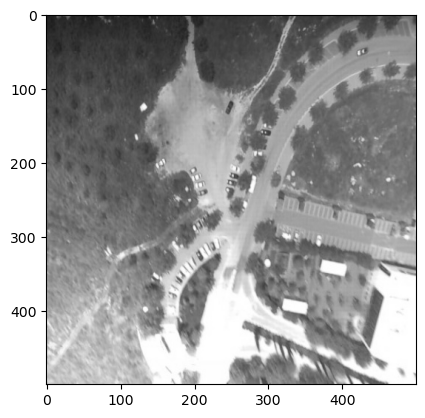

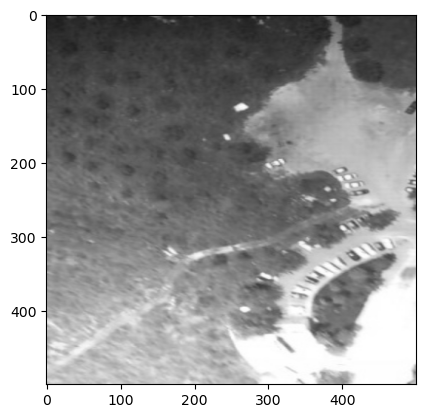

(500, 500, 3)


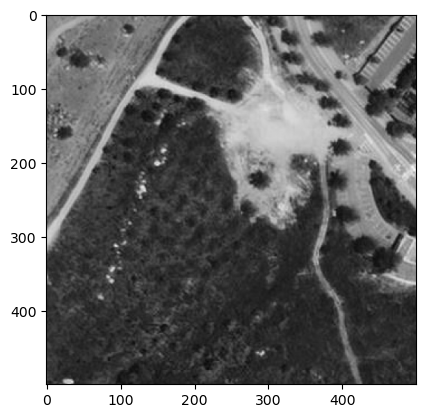

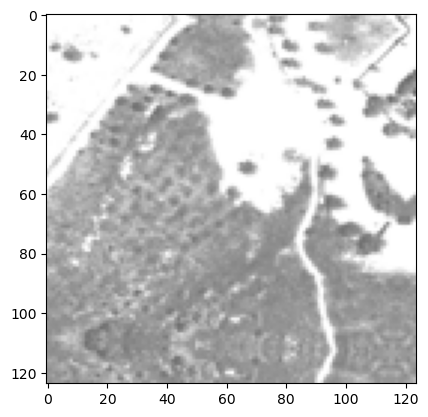

NameError: name 'model' is not defined

In [21]:
import albumentations as A

target_image = cv2.imread(config['benchmark data dolder'] + '/A.jpg')
#target_image = cv2.imread('/home/artl2sch/Desktop/L.png')

plt.imshow(target_image)
plt.show()


target_image = cv2.resize(target_image, (1000, 500))

target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)

target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)


target_image = np.array(target_image)

target_image = target_image[:500,0 : 500]


plt.imshow(target_image)
plt.show()

mview = MapView.from_xyz_rpy(-380, -120, 160, 0, 0, 0)
img_target = viewer.get_view(mview)
img_target = Image.fromarray(img_target)

print (np.array(img_target).shape)



#img_target = cv2.imread(config['benchmark data dolder'] + '/A.jpg')
#img_target = np.array(img_target)
#print (type(img_target), img_target.shape)

plt.imshow(img_target)
plt.show()

#img_target = target_image

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.7, contrast_limit=0.7, p=1.0),
    #A.PiecewiseAffine(p=0.3),
    #A.CoarseDropout(max_holes=8, max_height=200, max_width=200, min_holes=3, min_height=10, min_width=10),
    A.Blur(blur_limit=3, p=0.1),
    #A.ToGray(p = 1.0)
    A.ElasticTransform(p =1),
    #A.FDA([target_image], p=1, read_fn=lambda x: x), 
    #A.GaussNoise(p = 1), 
])

transformed = transform(image=np.array(img_target))
transformed_img = transformed["image"]

transformed_img = Image.fromarray(transformed_img)

#plt.imshow(transformed_img)
#plt.show()

plt.imshow(transformed_img.resize((124, 124)))
plt.show()


img_target = target_image 
#img_target = transformed_img


emb_target = SimCLR.get_single_embedding(config, model, img_target)



In [106]:
dist_arr = []

for emb in emb_arr:
    dist = np.sum((emb - emb_target)*(emb - emb_target))
    dist_arr.append(dist)

dist_arr = np.array(dist_arr)


min_idx_arr = np.argsort(dist_arr)

color_arr = (dist_arr - min(dist_arr))/(max(dist_arr) - min(dist_arr))
color_arr = 1 - (1 - color_arr)**10
color_arr*=255
#color_arr = (color_arr - min(color_arr))/(max(color_arr) - min(color_arr)) * 255


color_arr = np.array(color_arr, dtype = int)
color_arr = [(int(255 - c), 0, int(c)) for c in color_arr]

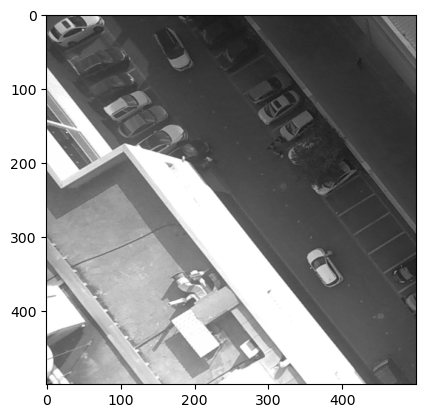

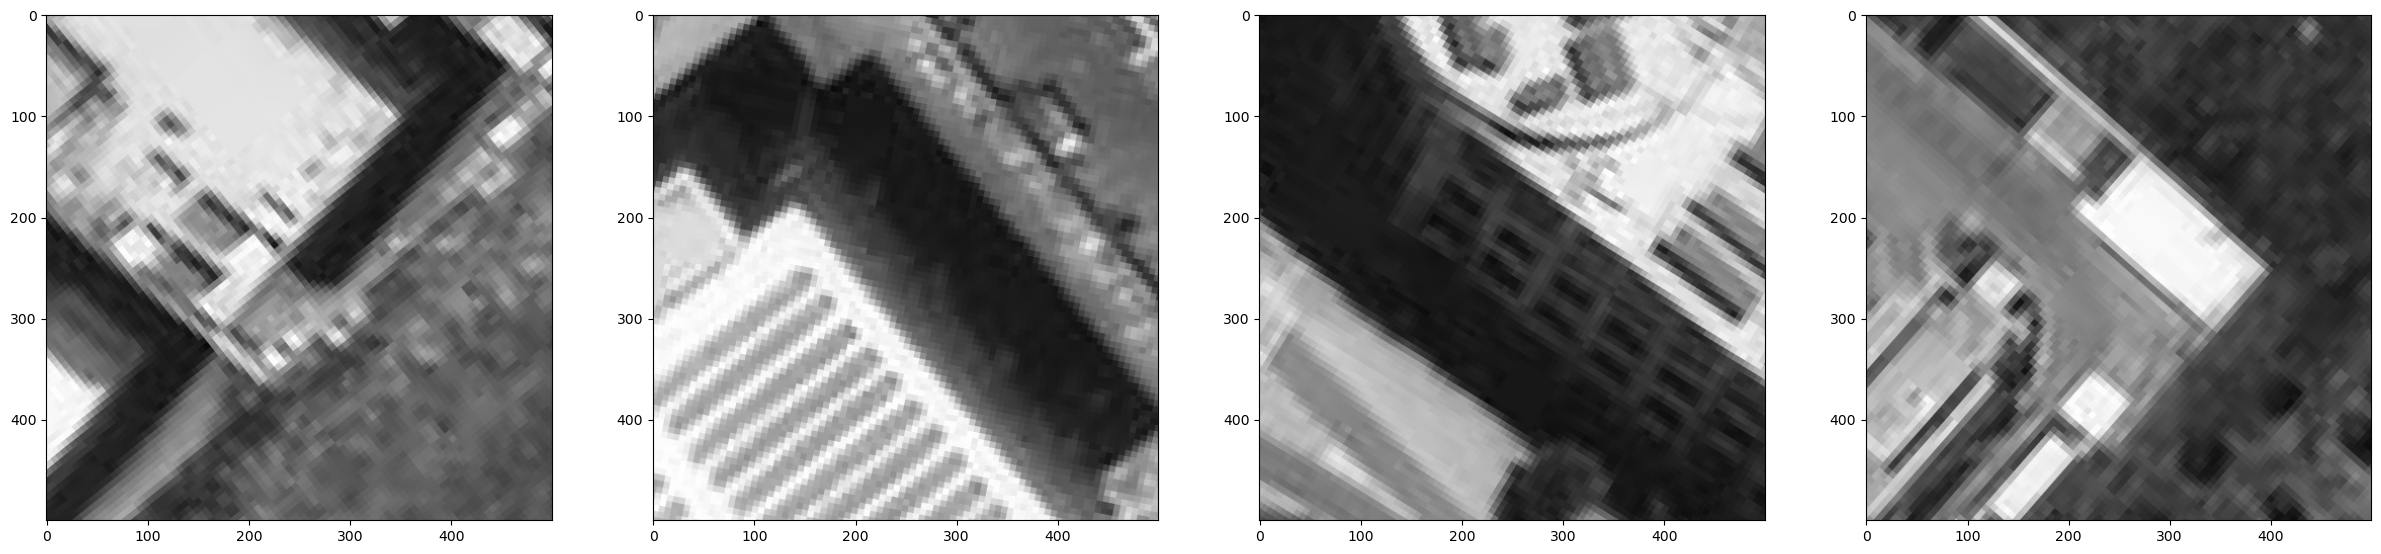

In [107]:

plt.imshow(img_target)
plt.show()

_, axs = plt.subplots(1, 4, figsize=(3*10, 3*6))
axs = axs.flatten()
for idx, ax in zip(range(4), axs):
    ax.imshow(img_arr[min_idx_arr[idx]])
plt.show()


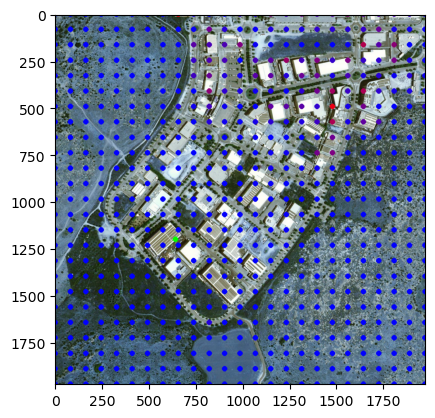

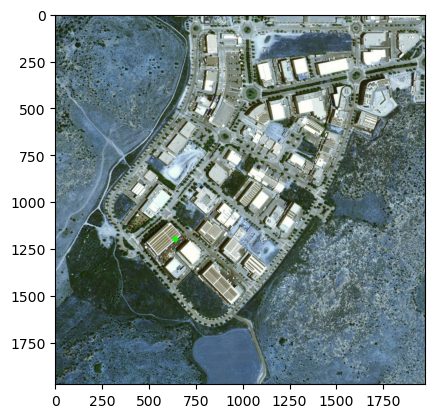

(31.88421, 34.96111)

In [108]:
mvec_arr = [MapVector.from_lla(mview.lla) for mview in mview_arr]

#color_arr.append(color_arr[0])
#mvec_arr.append(MapVector.from_xyz(-330, -80, 150))

unique_mvec_arr = []
unique_color_arr = []

for color, mvec in zip(color_arr, mvec_arr):
    is_unique = True
    for i in range(len(unique_mvec_arr)):
        if unique_mvec_arr[i].xyz['x'] == mvec.xyz['x'] and unique_mvec_arr[i].xyz['y'] == mvec.xyz['y']:
            is_unique = False
            if unique_color_arr[i][1] < color[1]:
                unique_color_arr[i] = color
                unique_mvec_arr[i] = mvec
    if is_unique:
        unique_mvec_arr.append(mvec)
        unique_color_arr.append(color)

#print (unique_color_arr)



region_img = map.display_mvec_arr_locations('0-0', [MapVector.from_lla(31.883560, 34.959805, 40, 50)] + unique_mvec_arr, color_arr = [(0, 255, 0)] + unique_color_arr) #[(0, 0, 13)]*len(mvec_arr)
plt.imshow(region_img)
plt.show()
region_img_2 = map.display_mvec_arr_locations('0-0', [MapVector.from_lla(31.883560, 34.959805, 40, 50)], color_arr = [(0, 255, 0)]) #[(0, 0, 13)]*len(mvec_arr)
plt.imshow(region_img_2)

plt.show()

#print (map.region_id_from_map_vec(mvec_arr[0]))

31.884210, 34.961110

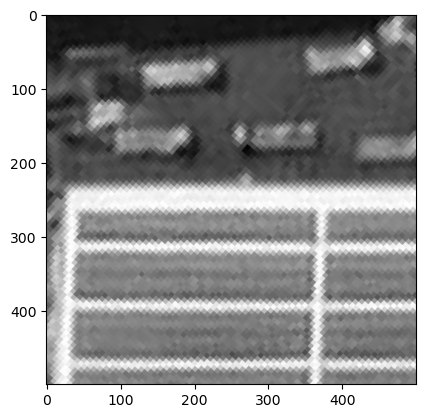

In [55]:
mview = MapView.from_lla_rpy(31.883560, 34.959805, 40, 0, 0, 1.23*np.pi)
img_target = viewer.get_view(mview)

plt.imshow(img_target)




In [4]:
import cv2
import torch
from albumentations import Resize, Compose
from albumentations.pytorch.transforms import  ToTensor
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
 
def preprocess_image(img_path, config):
    # transformations for the input data
    transforms = Compose([
        Resize(config['input size'], config['input size'], interpolation=cv2.INTER_NEAREST),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
     
    # read input image
    input_img = cv2.imread(img_path)
    # do transformations
    input_data = transforms(image = input_img)["image"]
    batch_data = torch.unsqueeze(input_data, 0)
    return batch_data

In [5]:
model.eval()
model.cuda()

t = time.time()

input = preprocess_image(config['benchmark data dolder'] + '/A.jpg', config)


t1 = time.time() - t
t = time.time()

input = input.cuda()
output = model(input)

t2 = time.time() - t

input.shape

torch.Size([1, 3, 128, 128])

In [6]:
input

tensor([[[[-1.5357, -1.5357, -1.5014,  ..., -0.3027, -0.3369, -0.7308],
          [-1.5357, -1.5185, -1.5014,  ..., -0.1828, -0.2684, -0.6281],
          [-1.4500, -1.4843, -1.6727,  ...,  0.1083, -0.1999, -0.7308],
          ...,
          [ 1.2557,  1.0673,  1.1187,  ...,  2.2318,  2.2489,  2.0948],
          [ 1.4440,  1.2557,  1.2385,  ...,  2.2147,  2.2318,  2.2147],
          [ 1.3242,  1.6667,  1.7180,  ...,  2.2318,  2.2489,  2.2318]],

         [[-1.4405, -1.4405, -1.4055,  ..., -0.1800, -0.2150, -0.6176],
          [-1.4405, -1.4230, -1.4055,  ..., -0.0574, -0.1450, -0.5126],
          [-1.3529, -1.3880, -1.5805,  ...,  0.2402, -0.0749, -0.6176],
          ...,
          [ 1.4132,  1.2206,  1.2731,  ...,  2.4111,  2.4286,  2.2710],
          [ 1.6057,  1.4132,  1.3957,  ...,  2.3936,  2.4111,  2.3936],
          [ 1.4832,  1.8333,  1.8859,  ...,  2.4111,  2.4286,  2.4111]],

         [[-1.2119, -1.2119, -1.1770,  ...,  0.0431,  0.0082, -0.3927],
          [-1.2119, -1.1944, -

In [7]:
import torch

input = input.repeat(250, 1, 1, 1)

ONNX_FILE_PATH = './Weights/model.onnx'
torch.onnx.export(model, input, ONNX_FILE_PATH, input_names=['input'],
                  output_names=['output'], export_params=True, verbose = True)

Exported graph: graph(%input : Float(100, 3, 128, 128, strides=[49152, 16384, 128, 1], requires_grad=0, device=cuda:0),
      %projection_head.layers.1.weight : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %projection_head.layers.1.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %projection_head.layers.1.running_mean : Float(512, strides=[1], requires_grad=0, device=cuda:0),
      %projection_head.layers.1.running_var : Float(512, strides=[1], requires_grad=0, device=cuda:0),
      %projection_head.layers.4.weight : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %projection_head.layers.4.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %projection_head.layers.4.running_mean : Float(128, strides=[1], requires_grad=0, device=cuda:0),
      %projection_head.layers.4.running_var : Float(128, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_209 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_g

In [11]:
import onnx

onnx_model = onnx.load(ONNX_FILE_PATH)
print (onnx.checker.check_model(onnx_model))

None


In [18]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import tensorrt as trt

In [19]:
TRT_LOGGER = trt.Logger()
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine(model_path):
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(EXPLICIT_BATCH) as network, builder.create_builder_config() as builder_config, trt.OnnxParser(network, TRT_LOGGER) as parser:
        #builder_config.max_workspace_size = 1<<20
        #builder_config.avg_timing_iterations = 8
        builder.max_batch_size = 1

        if builder.platform_has_fast_fp16:
            builder_config.set_flag(trt.BuilderFlag.FP16)


        with open(model_path, "rb") as f:
            parser.parse(f.read())
            
        engine = builder.build_engine(network, builder_config)

        context = engine.create_execution_context()


    return engine, context

In [20]:
engine, context = build_engine(ONNX_FILE_PATH)


for binding in engine:
    if engine.binding_is_input(binding):  # we expect only one input
        input_shape = engine.get_binding_shape(binding)
        input_size = trt.volume(input_shape) * engine.max_batch_size * np.dtype(np.float32).itemsize  # in bytes
        device_input = cuda.mem_alloc(input_size)
    else:  # and one output
        output_shape = engine.get_binding_shape(binding)
        # create page-locked memory buffers (i.e. won't be swapped to disk)
        host_output = cuda.pagelocked_empty(trt.volume(output_shape) * engine.max_batch_size, dtype=np.float32)
        device_output = cuda.mem_alloc(host_output.nbytes)

	
# Create a stream in which to copy inputs/outputs and run inference.
stream = cuda.Stream()


t = time.time()

host_input = np.array(preprocess_image(config['benchmark data dolder'] + '/A.jpg', config).numpy(), dtype=np.float32, order='C')

t1 = time.time() - t

t = time.time()

cuda.memcpy_htod_async(device_input, host_input, stream)

# run inference
context.execute_async(bindings=[int(device_input), int(device_output)], stream_handle=stream.handle)
cuda.memcpy_dtoh_async(host_output, device_output, stream)
stream.synchronize()

# postprocess results
output_data = torch.Tensor(host_output)#.reshape(engine.max_batch_size, output_shape[0])

t2 = time.time() - t


/tmp/ipykernel_40881/2452418483.py:8: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  builder.max_batch_size = 1
/tmp/ipykernel_40881/2452418483.py:17: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, builder_config)


[06/08/2023-00:35:28] [TRT] [W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[06/08/2023-00:35:28] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[06/08/2023-00:35:28] [TRT] [W] Check verbose logs for the list of affected weights.
[06/08/2023-00:35:28] [TRT] [W] - 24 weights are affected by this issue: Detected subnormal FP16 values.
[06/08/2023-00:35:28] [TRT] [W] - 10 weights are affected by this issue: Detected values less than smallest positive FP16 subnormal value and converted them to the FP16 minimum subnormalized value.
[06/08/2023-00:35:28] [TRT] [W] The getMaxBatchSize() function should not be used with an engine built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. This function will always return 1.
[06/08/2023-00:35:28] [TRT] [W] The getMaxBatchSize() function should not be used with an engine

/tmp/ipykernel_40881/1935293287.py:5: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):  # we expect only one input
/tmp/ipykernel_40881/1935293287.py:6: DeprecationWarning: Use get_tensor_shape instead.
  input_shape = engine.get_binding_shape(binding)
/tmp/ipykernel_40881/1935293287.py:7: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  input_size = trt.volume(input_shape) * engine.max_batch_size * np.dtype(np.float32).itemsize  # in bytes
/tmp/ipykernel_40881/1935293287.py:10: DeprecationWarning: Use get_tensor_shape instead.
  output_shape = engine.get_binding_shape(binding)
/tmp/ipykernel_40881/1935293287.py:12: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  host_output = cuda.pagelocked_empty(trt.volume(output_shape) * engine.max_batch_size, dtype=np.float32)
/tmp/ipykernel_40881/1935293287.py:31: DeprecationWarning: Use execu

In [21]:
output_data

tensor([ 0.3412, -1.1412, -0.9781, -1.2298,  1.6415, -1.9748,  1.3206,  0.1011,
         0.6165, -0.1169,  0.7115, -0.1141, -1.5442, -1.0303, -0.0429, -1.3748,
         1.3329, -0.5800, -0.9416,  0.4636,  0.1899,  0.8981, -0.8496, -0.2381,
        -0.6538, -0.5039,  0.9408, -0.5259,  0.4437, -0.2060, -1.1978, -0.1186,
        -0.6369, -1.0378, -0.3762,  0.0965,  0.0051,  1.4579,  0.8255,  0.6118,
        -0.4790,  0.6672,  0.4036,  0.9766, -0.2825, -0.0180,  0.2910,  0.3800,
         0.3430, -0.2985, -0.5624,  1.3101,  0.3550, -1.2611, -0.5621,  1.3543,
        -0.0728, -0.7957,  1.4932, -1.8382,  0.5246,  0.7159, -0.8995,  1.5363,
        -0.0872, -1.5811,  0.6460,  1.3606, -1.2886,  1.4034, -0.0619,  0.0688,
        -0.4543, -0.0088, -0.7953,  0.5147,  0.9202, -0.0891,  0.4516, -0.5480,
         1.3633, -1.1364,  0.7583, -0.7009, -0.4508, -0.4161,  0.3451, -0.4919,
         0.3995,  0.7995,  1.2431, -0.4181,  1.0041, -0.7394,  0.3519, -0.9626,
        -1.4189,  0.9788, -1.5571,  0.04

In [22]:
t1, t2

(0.0020704269409179688, 0.0005035400390625)

In [23]:
model.cuda()
input = preprocess_image(config['benchmark data dolder'] + '/A.jpg', config).cuda()
out = model(input)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [50]:
t = time.time()
host_input = np.array(preprocess_image(config['benchmark data dolder'] + '/A.jpg', config).numpy(), dtype=np.float32, order='C')
print (time.time() - t)

0.002534627914428711


In [1]:
mv = MapVector.from_xyz (100, 200, 300)

NameError: name 'MapVector' is not defined